<div style="display: flex; align-items: center;">
    <img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png" width="500" height="auto" height="auto" style="margin-right: 100px;" />
    <div>
        <p><strong>Prof. Dr. Thomas Nagel</strong></p>
        <p>Chair of Soil Mechanics and Foundation Engineering<br>Geotechnical Institute<br>Technische Universität Bergakademie Freiberg.</p>
        <p><a href="https://tu-freiberg.de/en/soilmechanics">https://tu-freiberg.de/en/soilmechanics</a></p>
    </div>
</div>

# Stresses around excavations in anistropic stress fields -- Towards integrity criteria

Consider a circular opening with radius $R$ in an infinite elastic medium subject to the compressive far-field stresses $\sigma_\text{max}$ at $\theta = \pi/2$ and $\sigma_\text{min} = \lambda \sigma_\text{max}$ at $\theta = 0$. In other words, $\lambda = \sigma_\text{min}/\sigma_\text{max}$ is the stress ratio.

Then, the stress solution is given as

$$
\begin{aligned}
    \sigma_{rr} &= \frac{\sigma_\text{max}}{2} \left[ (1+\lambda) \left( 1 - \frac{R^2}{r^2} \right) - (1-\lambda) \left( 1 - 4\frac{R^2}{r^2} + 3\frac{R^4}{r^4} \right) \cos 2\theta \right]
    \
    \sigma_{\theta\theta} &= \frac{\sigma_\text{max}}{2} \left[ (1+\lambda) \left( 1 + \frac{R^2}{r^2} \right) + (1-\lambda) \left( 1 + 3\frac{R^4}{r^4} \right) \cos 2\theta \right]
    \
    \sigma_{r\theta} &= \frac{\sigma_\text{max}}{2} \left[ (1-\lambda) \left( 1 + 2\frac{R^2}{r^2} - 3\frac{R^4}{r^4} \right) \sin 2\theta \right]
\end{aligned}
$$

Another stress solution describes the radial and circumferential stresses around a circular opening in response to an internal pressure $p$:

$$
\begin{aligned}
    \sigma_{rr} &= p \left( \frac{R}{r} \right)^2
    \
    \sigma_{\theta\theta} &= -p \left( \frac{R}{r} \right)^2
\end{aligned}
$$

Superposition of both solutions gives the solution for a pressurized circular opening in an anisotropic stress field:

$$
\begin{aligned}
    \sigma_{rr} &= \frac{\sigma_\text{max}}{2} \left[ (1+\lambda) \left( 1 - \frac{R^2}{r^2} \right) - (1-\lambda) \left( 1 - 4\frac{R^2}{r^2} + 3\frac{R^4}{r^4} \right) \cos 2\theta \right] + p \left( \frac{R}{r} \right)^2
    \
    \sigma_{\theta\theta} &= \frac{\sigma_\text{max}}{2} \left[ (1+\lambda) \left( 1 + \frac{R^2}{r^2} \right) + (1-\lambda) \left( 1 + 3\frac{R^4}{r^4} \right) \cos 2\theta \right] - p \left( \frac{R}{r} \right)^2
    \
    \sigma_{r\theta} &= \frac{\sigma_\text{max}}{2} \left[ (1-\lambda) \left( 1 + 2\frac{R^2}{r^2} - 3\frac{R^4}{r^4} \right) \sin 2\theta \right]
\end{aligned}
$$

Contour stresses:

In [2]:
#HIDDEN
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import concurrent.futures as cf
#HIDDEN
%run plot_functions/plot_settings.py
%run plot_functions/plot_dilatancy_excavation.ipynb

In [3]:
def reset_input_data():
    sigma_v = 12.e6 #Pa
    #input data in (mm,Pa, Pa, Pa):
    return {'R': 2.5,
              'smax': sigma_v,
              'smin': 0.5*sigma_v,
              'p': 1e5, #1atm as inner RB
            'A': 10e6,#Hoek Brown
            'B': 10e6,#Hoek Brown
            'sul': 1e6#tension limit
             }

input_data = reset_input_data()

Now let $\lambda \in [0,1]$, i.e. transitioning from a uniaxial to an isotropic far-field stress. What is the influence on the stress concentration ("Kerbwirkung")? The vertical far-field stress remains fixed at $12\,$MPa, the cavity is traction free.

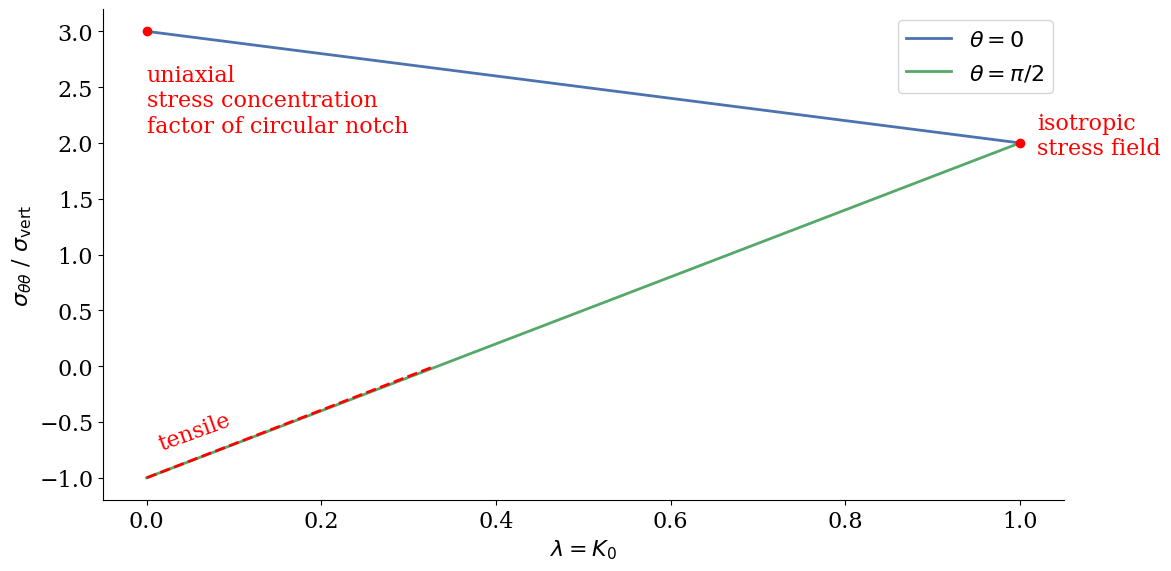

In [4]:
plot_anisotropy_variation()

Now we impose a normal traction of 1 atmosphere on the cavity and keep $\lambda = 0.5$ to look at field solutions.

In [5]:
input_data = reset_input_data()

In [6]:
#HIDDEN
#Run parallell analysis
t_rad = input_data['R']
X, Y = np.meshgrid(np.linspace(0.1,5*t_rad,1000),np.linspace(0.1,5*t_rad,1000))
#cylindical coordinates from Cartesian grid
r, theta = cart_to_cyl(X,Y)

s_rr_excav = radial_stress(r,theta,input_data)
s_tt_excav = circum_stress(r,theta,input_data)
s_rt_excav = shear_stress(r,theta,input_data)

s_rr_init = radial_stress(r+t_rad*1000,theta,input_data)
s_tt_init = circum_stress(r+t_rad*1000,theta,input_data)
s_rt_init = shear_stress(r+t_rad*1000,theta,input_data)

#doesn't get faster. ProcessPoolExecutor instead. But requires separate data structures.
n_threads = 6
#echt loopbar über dictionary
with cf.ProcessPoolExecutor(max_workers=n_threads) as executor:
    #independent matrices required so that executor feels thread safe
    A = executor.submit(forloop,int((0+0)/n_threads*len(X)),int((0+1)/n_threads*len(X)))
    B = executor.submit(forloop,int((0+1)/n_threads*len(X)),int((1+1)/n_threads*len(X)))
    C = executor.submit(forloop,int((0+2)/n_threads*len(X)),int((2+1)/n_threads*len(X)))
    D = executor.submit(forloop,int((0+3)/n_threads*len(X)),int((3+1)/n_threads*len(X)))
    E = executor.submit(forloop,int((0+4)/n_threads*len(X)),int((4+1)/n_threads*len(X)))
    F = executor.submit(forloop,int((0+5)/n_threads*len(X)),int((5+1)/n_threads*len(X)))

result = {}

for i in A.result():
    result[i] = np.append(A.result()[i],np.append(B.result()[i],np.append(C.result()[i],np.append(D.result()[i],np.append(E.result()[i],F.result()[i],0),0),0),0),0)

The stress solution along 0°, 45°, and 90° to the horizontal looks like this:

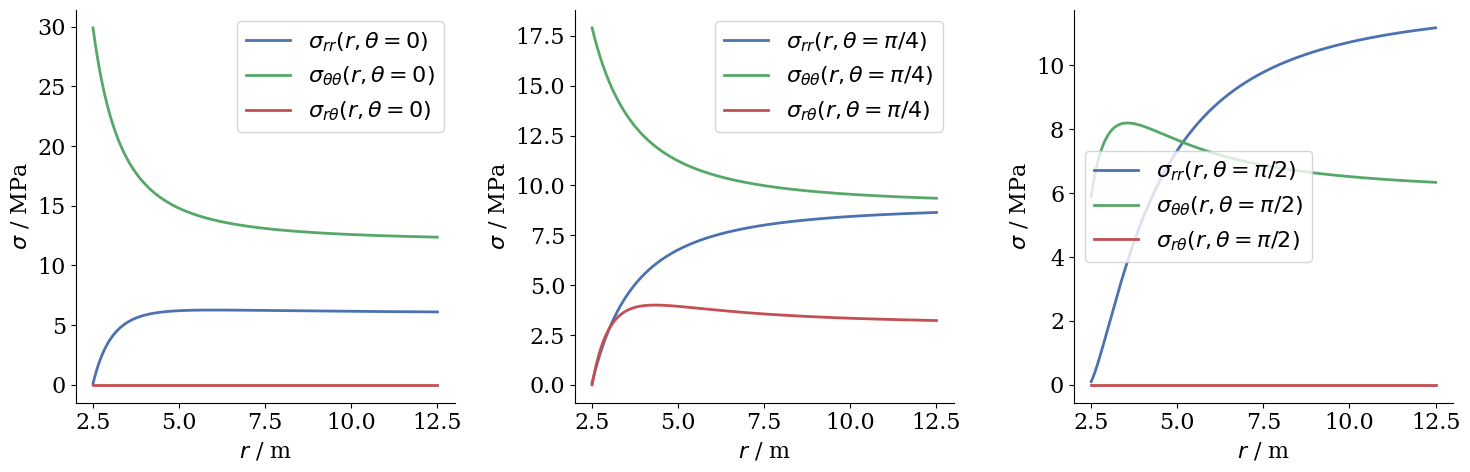

In [7]:
line_plot_stress_solution()

The following contour plots show the stress field in polar coordinates before excavation (top), after excavation (middle), and the stress change (bottom) between both states.

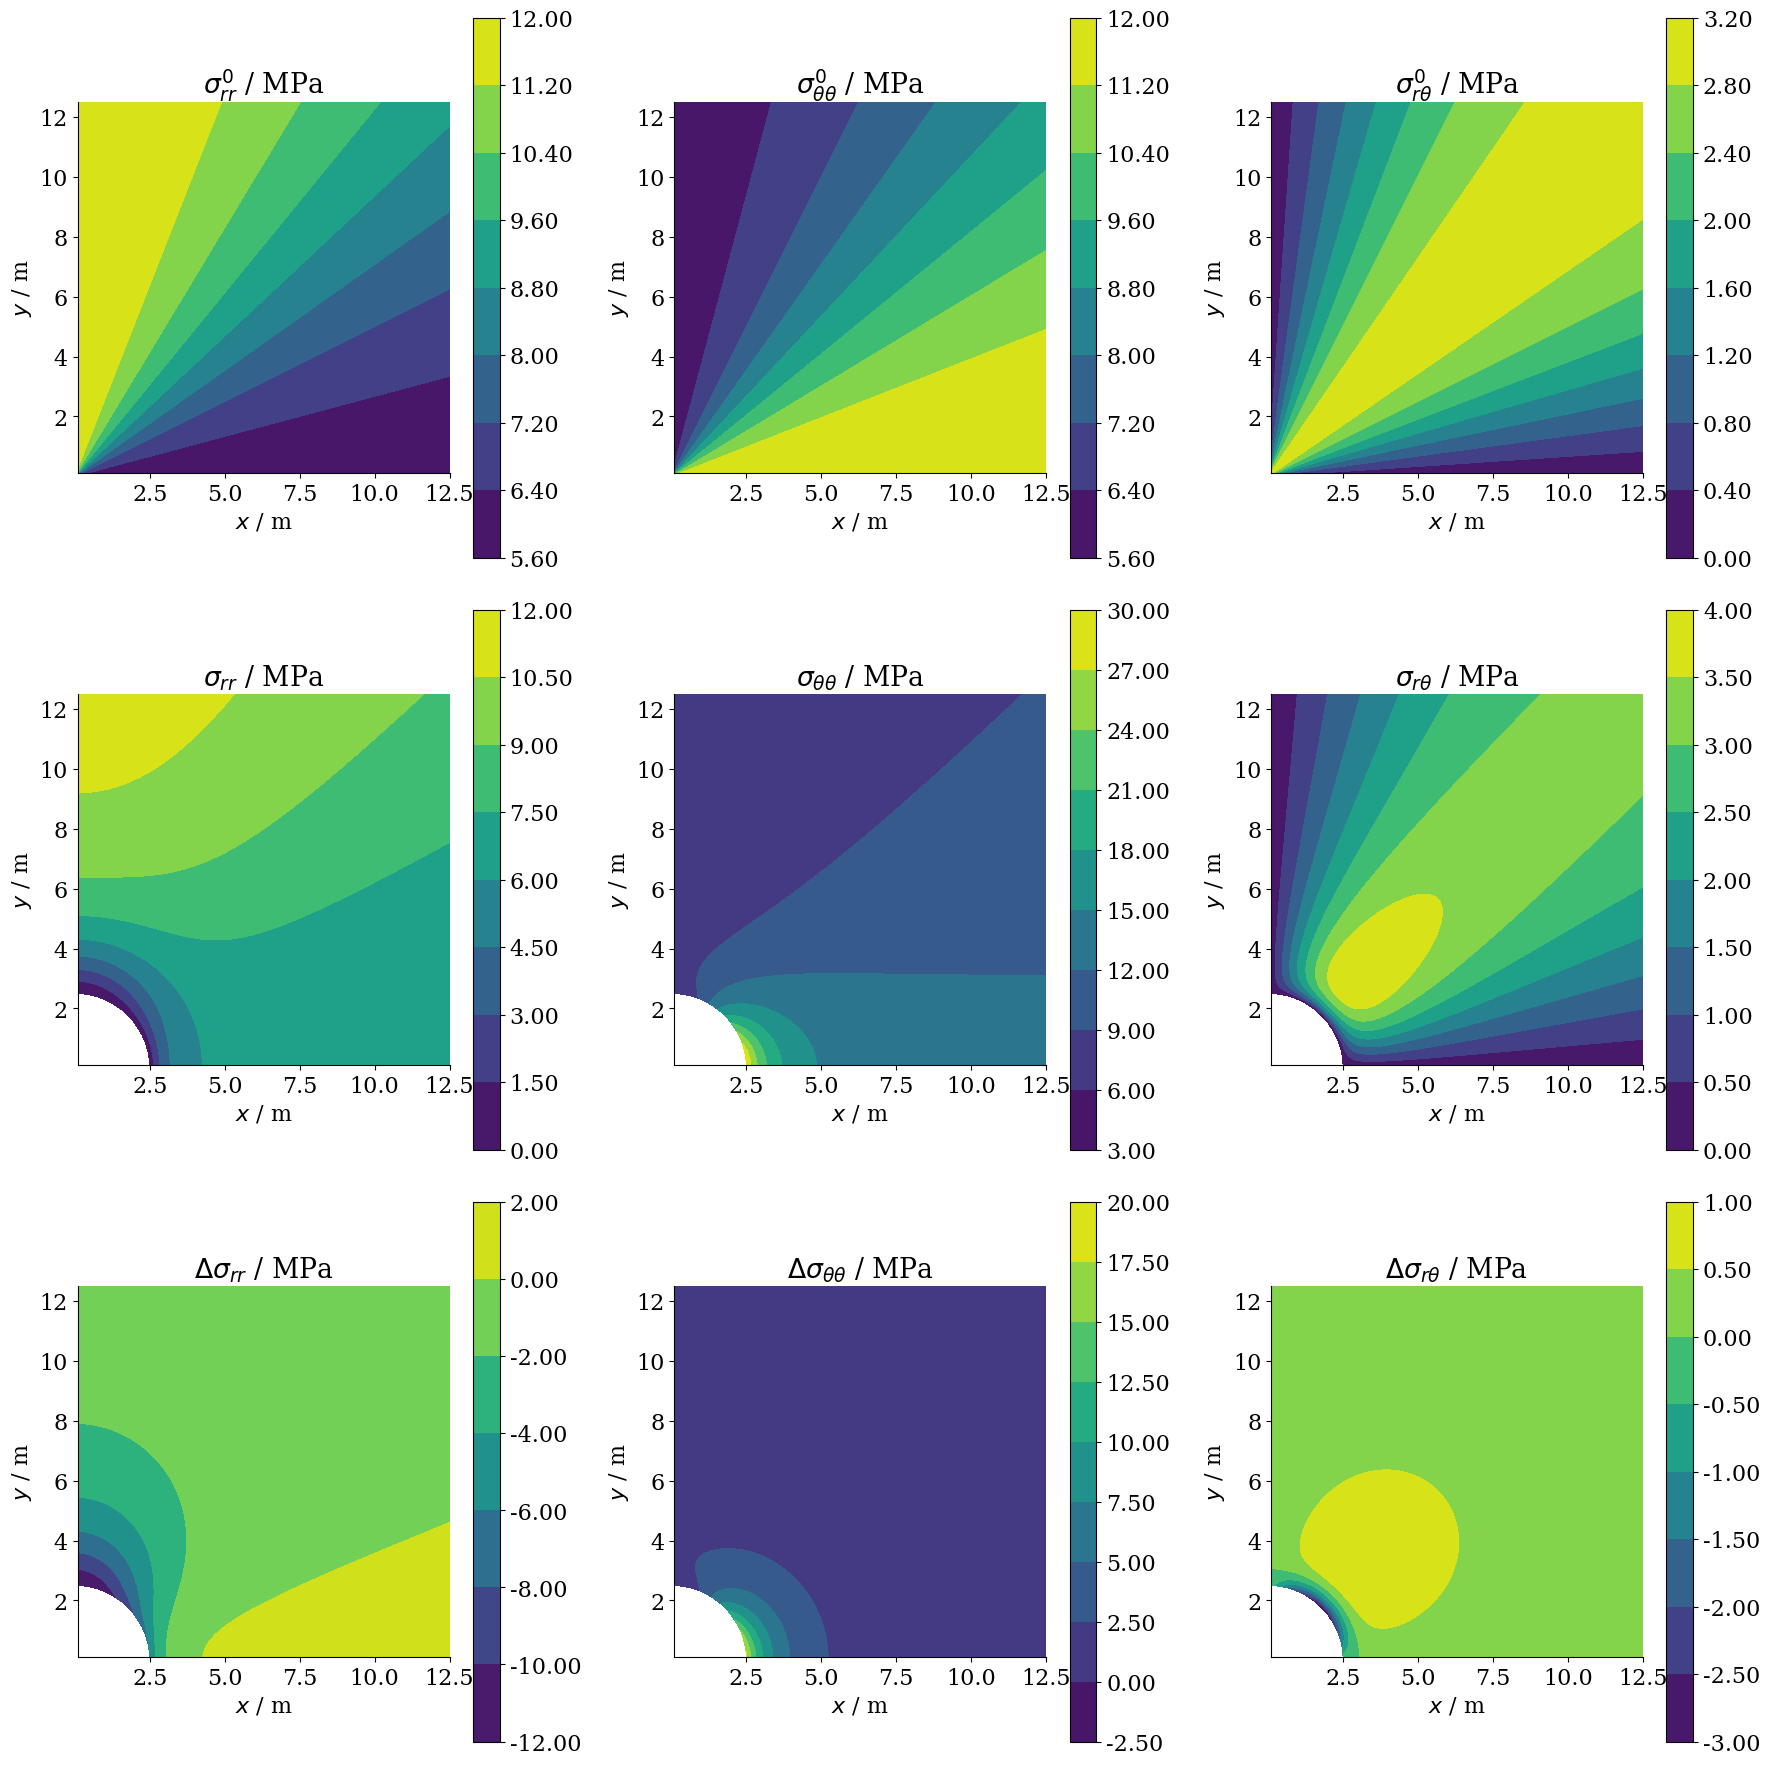

In [8]:
plot_stresses_polar()

The following contour plots show the principal values of the stress field and the maximum shear stress before excavation (top), after excavation (middle), and the stress change (bottom) between both states.

The streamlines show the principal stress trajectories, highligting the stress field rotation close to the excavation. The largest stress increase is parallel to the tunnel contour, while unloading occurs orthogonal to it.

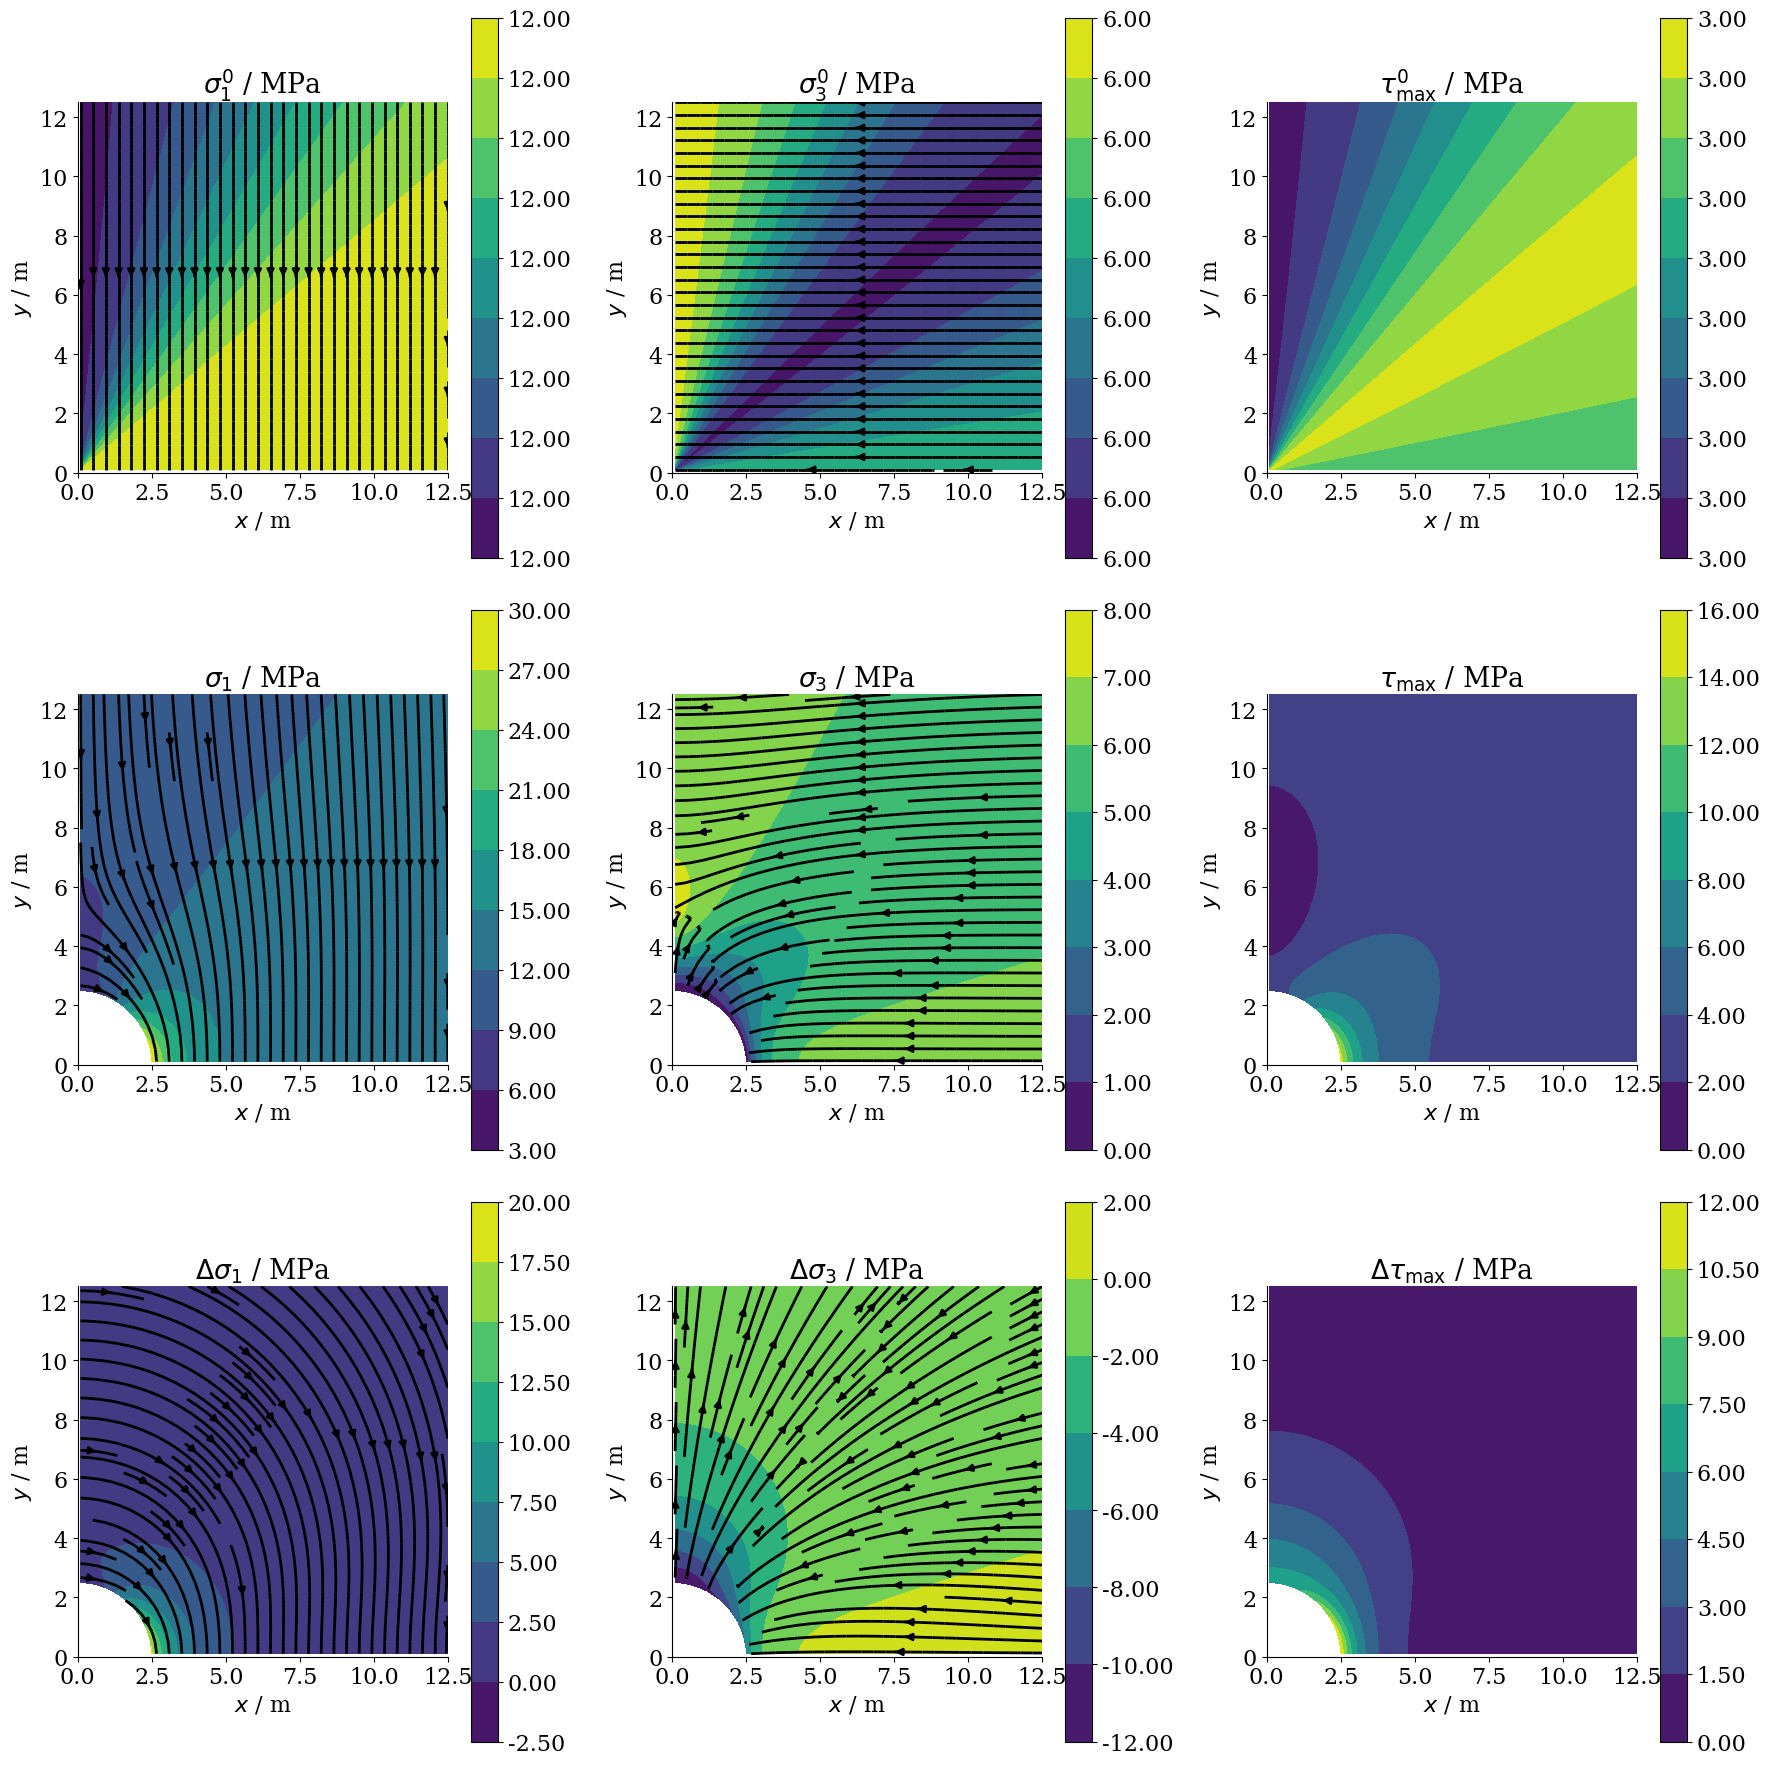

In [9]:
plot_stresses_principal()

Now we look at several potential integrita criteria. We start with the Hoek-Brown criterion (here arbirtary parameters) to evaluate the potential for dilatancy:

$$
    F_\text{HB} = \sigma_1 - \sigma_3 - \sqrt{A \sigma_3 + B^2}
$$

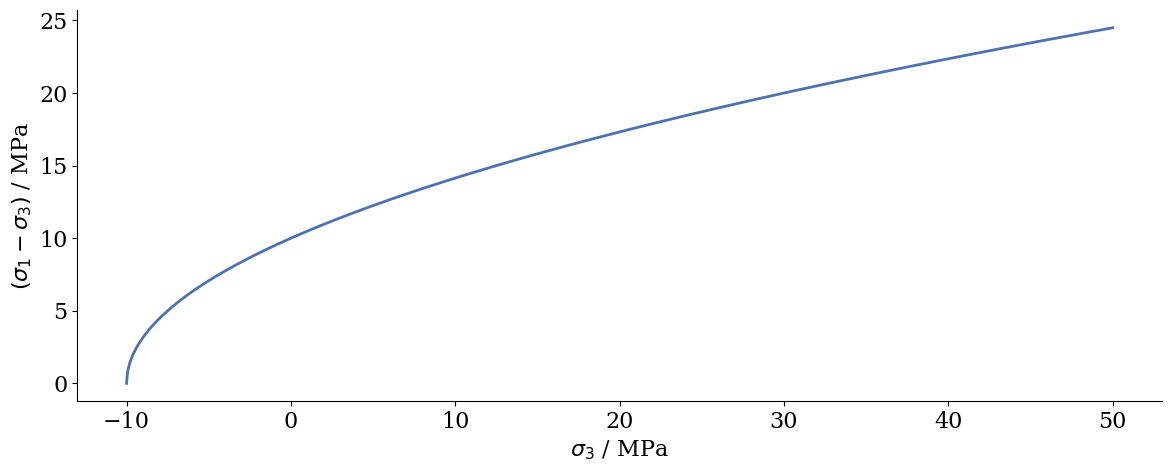

In [10]:
plot_HB()

As a second criterion we evaluate regions in which the maximum unloading, $\Delta\sigma_3$, exceeds a certain value (as a proxy for opening of fractures with a normal close to the corresponding principal direction; here no relation to fault stiffness or similar quantities, yet):

$$
    F_\text{ul} = -s_\text{ul}-\Delta\sigma_3
$$

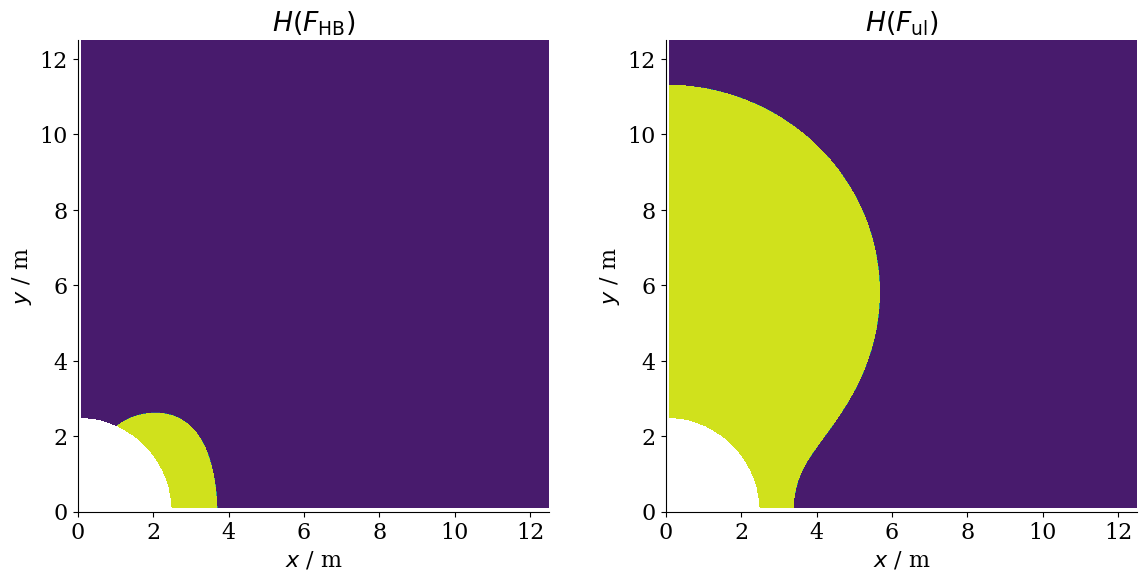

In [11]:
plot_failure()